In [1]:
!pip install caas_jupyter_tools pandas numpy

ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)
ERROR: No matching distribution found for caas_jupyter_tools


In [18]:
import pandas as pd
import numpy as np
import random

# Number of synthetic users
n = 10000

# Helper function: BMI calculation
def calculate_bmi(height_cm, weight_kg):
    height_m = height_cm / 100
    return round(weight_kg / (height_m ** 2), 1)

# Helper: convert score to 0–1 probability
def score_to_probability(score, max_score):
    prob = min(max(score / max_score, 0), 1)  # Normalize
    # Add slight randomness so not all same values
    return round(min(max(prob + random.uniform(-0.05, 0.05), 0), 1), 2)

# Risk scoring
def assign_risk(age, bmi, smoking, alcohol, activity, sleep, fruitveg, fam_hd, fam_db, bp_sys, bp_dia, glucose, cholesterol, existing):
    risks = {}

    # Cardiovascular
    cardio_score = 0
    if age > 50: cardio_score += 2
    if bp_sys > 140 or bp_dia > 90: cardio_score += 2
    if cholesterol > 240: cardio_score += 2
    if smoking == "current": cardio_score += 2
    if fam_hd: cardio_score += 1
    if activity == "low": cardio_score += 1
    risks["Cardiovascular"] = score_to_probability(cardio_score, 10)

    # Metabolic / Endocrine
    metabolic_score = 0
    if bmi >= 30: metabolic_score += 2
    if glucose >= 126: metabolic_score += 2
    if fam_db: metabolic_score += 1
    if activity == "low": metabolic_score += 1
    if cholesterol > 240: metabolic_score += 1
    risks["Metabolic_Endocrine"] = score_to_probability(metabolic_score, 8)

    # Respiratory
    resp_score = 0
    if smoking == "current": resp_score += 2
    if bmi >= 35: resp_score += 1
    if sleep < 6: resp_score += 1
    if existing in ["asthma", "copd"]: resp_score += 2
    risks["Respiratory"] = score_to_probability(resp_score, 6)

    # Liver
    liver_score = 0
    if alcohol == "regular": liver_score += 3
    if bmi >= 30: liver_score += 1
    if glucose >= 126: liver_score += 1
    if cholesterol > 240: liver_score += 1
    risks["Liver"] = score_to_probability(liver_score, 6)

    # Nutritional
    nutri_score = 0
    if fruitveg < 2: nutri_score += 2
    if activity == "low": nutri_score += 1
    if bmi < 18.5 or bmi >= 30: nutri_score += 1
    risks["Nutritional"] = score_to_probability(nutri_score, 4)

    return risks

# Categories for random selection
gender_choices = ["male", "female"]
smoking_choices = ["never", "former", "current"]
alcohol_choices = ["none", "occasional", "regular"]
activity_choices = ["low", "moderate", "high"]
existing_conditions_choices = [None, "asthma", "copd", "hypertension", "diabetes"]

# Generate dataset
records = []
for _ in range(n):
    age = random.randint(18, 80)
    gender = random.choice(gender_choices)
    height = random.randint(150, 190)
    weight = random.randint(45, 120)
    bmi = calculate_bmi(height, weight)
    smoking = random.choice(smoking_choices)
    alcohol = random.choice(alcohol_choices)
    activity = random.choice(activity_choices)
    sleep = random.randint(4, 9)
    fruitveg = random.randint(0, 5)
    fam_hd = bool(random.getrandbits(1))
    fam_db = bool(random.getrandbits(1))
    existing = random.choice(existing_conditions_choices)
    bp_sys = random.randint(100, 180)
    bp_dia = random.randint(60, 110)
    glucose = random.randint(70, 200)
    cholesterol = random.randint(150, 300)

    # Assign risk probabilities
    risks = assign_risk(age, bmi, smoking, alcohol, activity, sleep, fruitveg, fam_hd, fam_db, bp_sys, bp_dia, glucose, cholesterol, existing)

    record = {
        "Age": age,
        "Gender": gender,
        "Height_cm": height,
        "Weight_kg": weight,
        "BMI": bmi,
        "SmokingStatus": smoking,
        "AlcoholUse": alcohol,
        "ActivityLevel": activity,
        "SleepHours": sleep,
        "FruitVegIntake": fruitveg,
        "FamilyHistory_HeartDisease": fam_hd,
        "FamilyHistory_Diabetes": fam_db,
        "ExistingConditions": existing,
        "BP_Systolic": bp_sys,
        "BP_Diastolic": bp_dia,
        "FastingGlucose": glucose,
        "Cholesterol": cholesterol,
        "Risk_Cardiovascular": risks["Cardiovascular"],
        "Risk_Metabolic_Endocrine": risks["Metabolic_Endocrine"],
        "Risk_Respiratory": risks["Respiratory"],
        "Risk_Liver": risks["Liver"],
        "Risk_Nutritional": risks["Nutritional"]
    }
    records.append(record)

# Create DataFrame
df = pd.DataFrame(records)

# Save to CSV
df.to_csv("synthetic_health_data_probabilities.csv", index=False)
print("Dataset generated: synthetic_health_data_probabilities.csv")


Dataset generated: synthetic_health_data_probabilities.csv


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("synthetic_health_data_probabilities.csv")

# Target columns from your dataset
target_cols = [
    "Risk_Cardiovascular",
    "Risk_Metabolic_Endocrine",
    "Risk_Respiratory",
    "Risk_Liver",
    "Risk_Nutritional"
]

# Convert categorical columns to numeric (for model)
df_encoded = pd.get_dummies(df, columns=["Gender", "SmokingStatus", "AlcoholUse", "ActivityLevel", "ExistingConditions"], drop_first=True)

# Features and Targets
X = df_encoded.drop(columns=target_cols)
Y = df_encoded[target_cols]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Model
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# Train
model.fit(X_train, Y_train)

# Predict
Y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(Y_test, Y_pred, multioutput='uniform_average')
r2 = r2_score(Y_test, Y_pred, multioutput='uniform_average')

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Example prediction for a sample input
sample_input = pd.DataFrame([[
    30, "male", 175, 75, 24.5, "current", "none", "moderate", 7, 3,
    False, False, None, 120, 80, 90, 180
]], columns=[
    "Age", "Gender", "Height_cm", "Weight_kg", "BMI", "SmokingStatus",
    "AlcoholUse", "ActivityLevel", "SleepHours", "FruitVegIntake",
    "FamilyHistory_HeartDisease", "FamilyHistory_Diabetes", "ExistingConditions",
    "BP_Systolic", "BP_Diastolic", "FastingGlucose", "Cholesterol"
])

# Encode sample input same as training
sample_input_encoded = pd.get_dummies(sample_input)
sample_input_encoded = sample_input_encoded.reindex(columns=X.columns, fill_value=0)

# Prediction
sample_pred = model.predict(sample_input_encoded)
print("Predicted Risks (0–1 scale):", np.round(sample_pred[0], 3))


MSE: 0.0097
R²: 0.8247
Predicted Risks (0–1 scale): [0.384 0.042 0.5   0.014 0.018]


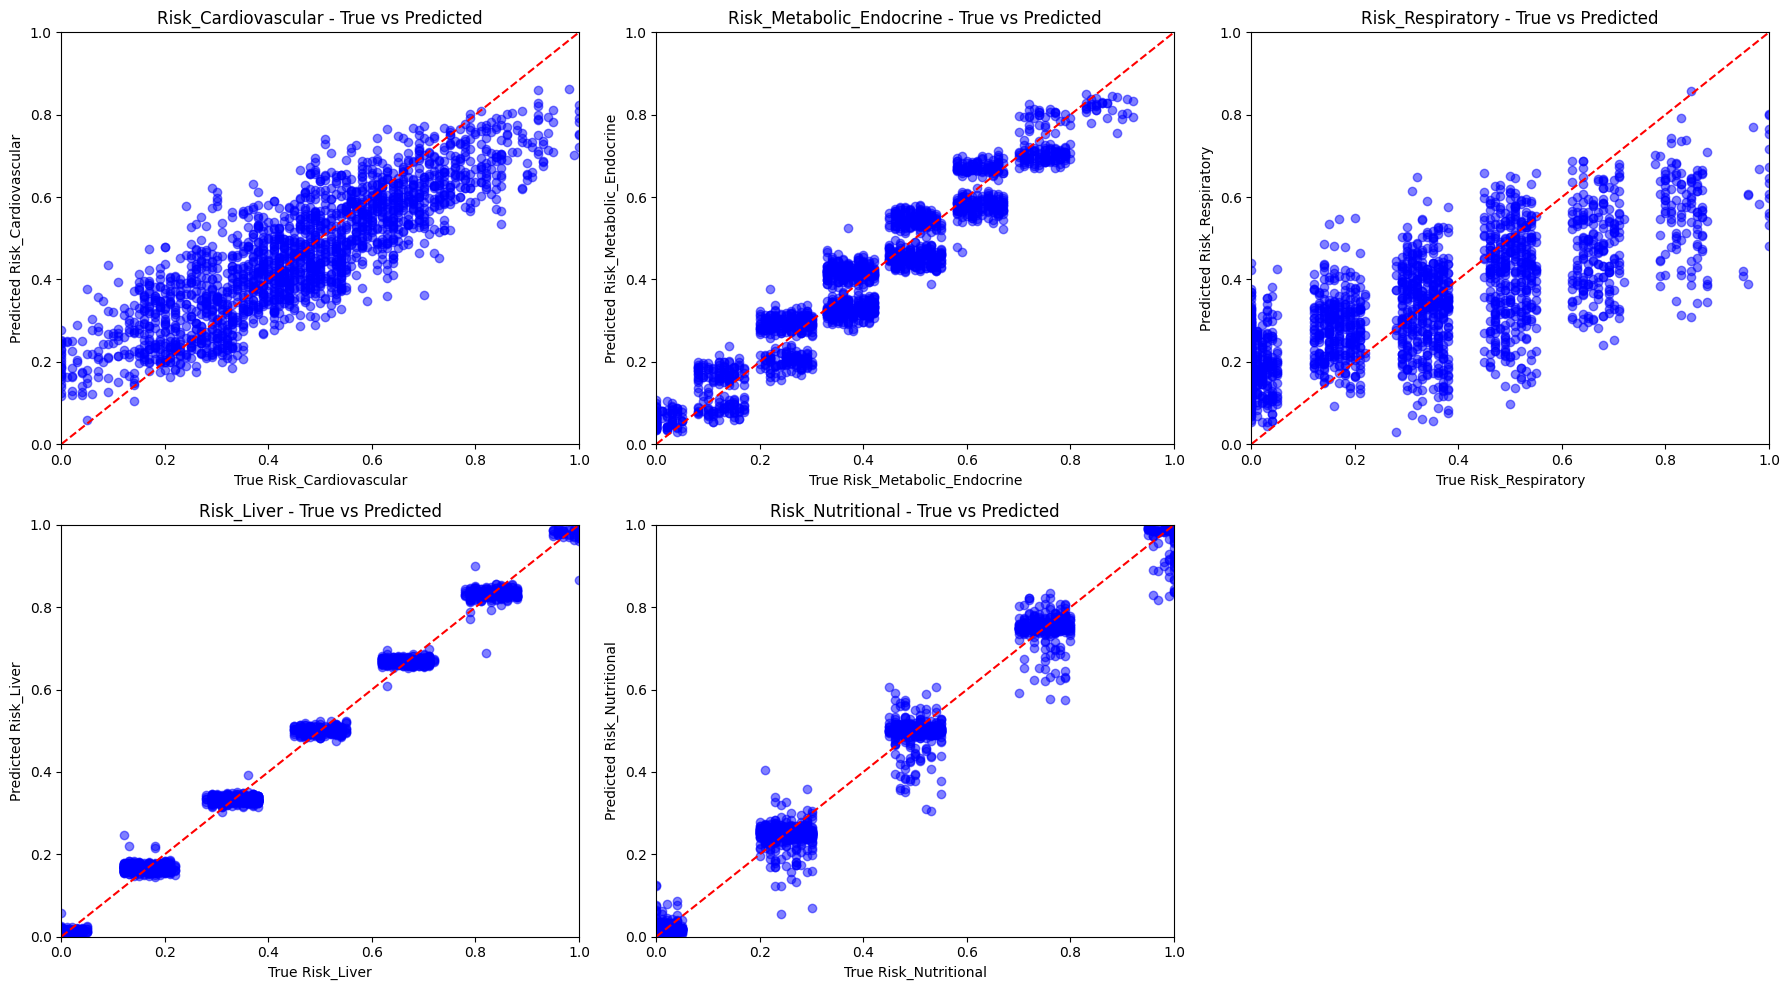

In [20]:
import matplotlib.pyplot as plt

# Plot predicted vs true for each risk
risk_cols = [
    "Risk_Cardiovascular",
    "Risk_Metabolic_Endocrine",
    "Risk_Respiratory",
    "Risk_Liver",
    "Risk_Nutritional"
]

plt.figure(figsize=(18, 10))

for i, col in enumerate(risk_cols, 1):
    plt.subplot(2, 3, i)
    plt.scatter(Y_test[col], Y_pred[:, i-1], alpha=0.5, color='blue')
    plt.plot([0, 1], [0, 1], 'r--')  # ideal diagonal line
    plt.xlabel("True " + col)
    plt.ylabel("Predicted " + col)
    plt.title(f"{col} - True vs Predicted")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [21]:
import joblib

# Save model
joblib.dump(model, "health_risk_model.pkl")
print("Model saved as health_risk_model.pkl")

Model saved as health_risk_model.pkl


In [ ]:
#loaded_model = joblib.load("health_risk_model.pkl")

In [22]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor

# --- 1. Load your trained model from pickle ---
# Agar abhi pickle file nahi banai, pehle:
# joblib.dump(model, "health_risk_model.pkl")
loaded_model = joblib.load("health_risk_model.pkl")
print("Model loaded successfully!")

# --- 2. Prepare a test input ---
# Columns must match training data
test_input = pd.DataFrame([[
    90, "male", 170, 70, 24.2, "current", "occasional", "moderate", 6, 2,
    False, True, None, 130, 85, 100, 210
]], columns=[
    "Age", "Gender", "Height_cm", "Weight_kg", "BMI", "SmokingStatus",
    "AlcoholUse", "ActivityLevel", "SleepHours", "FruitVegIntake",
    "FamilyHistory_HeartDisease", "FamilyHistory_Diabetes", "ExistingConditions",
    "BP_Systolic", "BP_Diastolic", "FastingGlucose", "Cholesterol"
])

# --- 3. Encode categorical features exactly like during training ---
test_input_encoded = pd.get_dummies(test_input)
# Align columns with training data
X_columns = loaded_model.feature_names_in_  # RandomForest from scikit-learn >=1.0 stores feature names
test_input_encoded = test_input_encoded.reindex(columns=X_columns, fill_value=0)

# --- 4. Predict risks ---
predicted_risks = loaded_model.predict(test_input_encoded)
predicted_risks = predicted_risks[0]  # single row

# --- 5. Display results ---
risk_cols = [
    "Risk_Cardiovascular",
    "Risk_Metabolic_Endocrine",
    "Risk_Respiratory",
    "Risk_Liver",
    "Risk_Nutritional"
]

for name, value in zip(risk_cols, predicted_risks):
    print(f"{name}: {round(value*100, 1)}%")


Model loaded successfully!
Risk_Cardiovascular: 46.1%
Risk_Metabolic_Endocrine: 9.9%
Risk_Respiratory: 51.0%
Risk_Liver: 1.4%
Risk_Nutritional: 1.2%


In [27]:
!ls -la;


total 309356
drwxr-xr-x 1 root root      4096 Aug 14 19:20 .
drwxr-xr-x 1 root root      4096 Aug 14 19:00 ..
drwxr-xr-x 4 root root      4096 Aug 13 13:41 .config
-rw-r--r-- 1 root root 315718577 Aug 14 19:19 health_risk_model.pkl
drwxr-xr-x 2 root root      4096 Aug 14 19:10 .ipynb_checkpoints
-rw-r--r-- 1 root root         0 Aug 14 19:20 ram.txt
drwxr-xr-x 1 root root      4096 Aug 13 13:42 sample_data
-rw-r--r-- 1 root root   1035134 Aug 14 19:18 synthetic_health_data_probabilities.csv
